# Movie Recommandation System

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import datetime
import random

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1. Loading the data

In [2]:
users_title = ['userID', 'gender', 'age', 'occupationID', 'zip-code']
users_old = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
print(users_old.shape)
users_old.head()

(6040, 5)


,userID,gender,age,occupationID,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [3]:
movies_title = ['movieID', 'title', 'genres']
movies_old = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
print(movies_old.shape)
movies_old.head()

(3883, 3)


,movieID,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_title = ['userID','movieID', 'rating', 'timestamps']
ratings_old = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
print(ratings_old.shape)
ratings_old.head()

(1000209, 4)


,userID,movieID,rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 2. Dara Preprocessing:

In [5]:
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')

# Mapping gender to number[0, 1] 
users['gender'] = users['gender'].astype('category')
users['gender'] = users['gender'].cat.codes

# Mapping age range from age gourp to 0 - 7
age_mapping = {1: 0, 18: 1, 25: 2, 35: 3, 45: 4, 50: 5, 56: 6}
users['age'] = users['age'].map(age_mapping)

# Dropping the zip-code columm
# users.drop('zip-code')
users.drop('zip-code', axis=1, inplace=True)

print("User table after preprocessing")
users.head()

User table after preprocessing


,userID,gender,age,occupationID
0,1,0,0,10
1,2,1,6,16
2,3,1,2,15
3,4,1,4,7
4,5,1,2,20


In [6]:
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')

# Mapping the genres to the fixed length (len = 18) padded list
genres_types = ["Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", 
                "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", 
                "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]

def genresToList(s):
    result = [genres_types.index(g) + 1 for g in s.split("|")]
    result = result + [0 for i in range(18 - len(result))]
    return result;
    
movies['genres'] = movies['genres'].apply(genresToList)

# Remove year from title and mapping the title to the fixed length (len = 18) padded list
def removeYear(s):
    return s[:-7]
movies['title'] = movies['title'].apply(removeYear)

title_words = set()
for title in movies["title"]:
    for word in title.split(" "):
        title_words.add(word)
title_words = list(title_words)
        
def titleToList(s):
    result = [title_words.index(g) + 1 for g in s.split(" ")]
    result = result + [0 for i in range(15 - len(result))]
    return result;

movies['title'] = movies['title'].apply(titleToList)

print("Movie table after preprocessing")
movies.head()

Movie table after preprocessing


,movieID,title,genres
0,1,"[4402, 3830, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[2282, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 4, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,"[2346, 3282, 4261, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,4,"[3285, 2115, 4434, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,"[1357, 2495, 52, 5162, 958, 3482, 0, 0, 0, 0, ...","[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings.drop('timestamps', axis=1, inplace=True)

print("Rating table after preprocessing")
ratings.head()

Rating table after preprocessing


,userID,movieID,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [8]:
data = pd.merge(pd.merge(ratings, users), movies)

X_df, y_df = data.drop('rating', axis=1), data['rating']
    
X_all = X_df.values
y_all = y_df.values

## 3. Building the Network

In [9]:
print("User table dimensions:")
user_id_count = users['userID'].nunique()+1
print("user_id_count:", user_id_count)

user_gender_count = users['gender'].nunique()
print("user_gender_count:", user_gender_count)

user_age_count = users['age'].nunique()
print("user_age_count:", user_age_count)

user_occupation_count = users['occupationID'].nunique()
print("user_occupation_count:", user_occupation_count)


print("\nMovies table dimensions:")
movie_id_count = max(movies["movieID"]) + 1
print("movie_id_count:", movie_id_count)

movie_title_count = len(title_words) + 1
print("movies_title_count:", movie_title_count)

movie_title_len = 15
print("movies_title_len:", movie_title_len)

movie_genres_count = len(genres_types) + 1
print("movies_genres_count:", movie_genres_count)

movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

User table dimensions:
user_id_count: 6041
user_gender_count: 2
user_age_count: 7
user_occupation_count: 21

Movies table dimensions:
movie_id_count: 3953
movies_title_count: 5215
movies_title_len: 15
movies_genres_count: 19


In [10]:
class MovieRecommendationModel():
    def __init__(self, learning_rate, embed_dim = 32, filter_num = 8, window_sizes = {2, 3, 4, 5}):
        
        self.dropout_keep_prob = tf.placeholder(tf.float32)
        self.ratings = tf.placeholder(tf.int32, [None, 1])
        
        ###########################
        # User Features Embedding #
        ###########################
        self.user_id = tf.placeholder(tf.int32, [None, 1])
        self.user_gender = tf.placeholder(tf.int32, [None, 1])
        self.user_age = tf.placeholder(tf.int32, [None, 1])
        self.user_job = tf.placeholder(tf.int32, [None, 1])
        
        uid_embed_matrix = tf.Variable(tf.random_uniform([user_id_count, embed_dim], -1, 1))
        uid_embed_layer = tf.nn.embedding_lookup(uid_embed_matrix, self.user_id)
    
        gender_embed_matrix = tf.Variable(tf.random_uniform([user_gender_count, embed_dim // 2], -1, 1))
        gender_embed_layer = tf.nn.embedding_lookup(gender_embed_matrix, self.user_gender)
        
        age_embed_matrix = tf.Variable(tf.random_uniform([user_age_count, embed_dim // 2], -1, 1))
        age_embed_layer = tf.nn.embedding_lookup(age_embed_matrix, self.user_age)
        
        job_embed_matrix = tf.Variable(tf.random_uniform([user_occupation_count, embed_dim // 2], -1, 1))
        job_embed_layer = tf.nn.embedding_lookup(job_embed_matrix, self.user_job)

        # First FC 
        uid_fc_layer = tf.layers.dense(uid_embed_layer, embed_dim, activation=tf.nn.relu)
        gender_fc_layer = tf.layers.dense(gender_embed_layer, embed_dim, activation=tf.nn.relu)
        age_fc_layer = tf.layers.dense(age_embed_layer, embed_dim, activation=tf.nn.relu)
        job_fc_layer = tf.layers.dense(job_embed_layer, embed_dim, activation=tf.nn.relu)
        
        # Second FC
        user_combine_layer = tf.concat([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  
        user_combine_layer = tf.contrib.layers.fully_connected(user_combine_layer, 200, tf.tanh)  
        self.user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 200])
        
        
        #############################
        # Movies Features Embedding #
        #############################
        self.movie_id = tf.placeholder(tf.int32, [None, 1])
        self.movie_genres = tf.placeholder(tf.int32, [None, 18])
        self.movie_titles = tf.placeholder(tf.int32, [None, 15])
        
        movie_id_embed_matrix = tf.Variable(tf.random_uniform([movie_id_count, embed_dim], -1, 1))
        movie_id_embed_layer = tf.nn.embedding_lookup(movie_id_embed_matrix, self.movie_id)
        
        movie_genres_embed_matrix = tf.Variable(tf.random_uniform([movie_genres_count, embed_dim], -1, 1))
        movie_genres_embed_layer = tf.nn.embedding_lookup(movie_genres_embed_matrix, self.movie_genres)
        movie_genres_embed_layer = tf.reduce_sum(movie_genres_embed_layer, axis=1, keep_dims=True)
        
        movie_title_embed_matrix = tf.Variable(tf.random_uniform([movie_title_count, embed_dim], -1, 1))
        movie_title_embed_layer = tf.nn.embedding_lookup(movie_title_embed_matrix, self.movie_titles)
        movie_title_embed_layer_expand = tf.expand_dims(movie_title_embed_layer, -1)
    
        # CNN layer for movie titles
        pool_layer_lst = []
        for window_size in window_sizes:
            filter_weights = tf.Variable(tf.truncated_normal([window_size, embed_dim, 1, filter_num],stddev=0.1))
            filter_bias = tf.Variable(tf.constant(0.1, shape=[filter_num]))
            
            conv_layer = tf.nn.conv2d(movie_title_embed_layer_expand, filter_weights, [1,1,1,1], padding="VALID")
            relu_layer = tf.nn.relu(tf.nn.bias_add(conv_layer,filter_bias))
            
            maxpool_layer = tf.nn.max_pool(relu_layer, [1,movie_title_len - window_size + 1 ,1,1], [1,1,1,1], padding="VALID")
            pool_layer_lst.append(maxpool_layer)

        
        pool_layer = tf.concat(pool_layer_lst, 3)
        max_num = len(window_sizes) * filter_num
        pool_layer_flat = tf.reshape(pool_layer , [-1, 1, max_num])

        dropout_layer = tf.nn.dropout(pool_layer_flat, self.dropout_keep_prob)
        
        # First FC 
        movie_id_fc_layer = tf.layers.dense(movie_id_embed_layer, embed_dim, activation=tf.nn.relu)
        movie_genres_fc_layer = tf.layers.dense(movie_genres_embed_layer, embed_dim, activation=tf.nn.relu)
    
        # Second FC
        movie_combine_layer = tf.concat([movie_id_fc_layer, movie_genres_fc_layer, dropout_layer], 2)  
        movie_combine_layer = tf.contrib.layers.fully_connected(movie_combine_layer, 200, tf.tanh)  
        self.movie_combine_layer_flat = tf.reshape(movie_combine_layer, [-1, 200])
        
        
        pred_ratings = tf.reduce_sum(self.user_combine_layer_flat * self.movie_combine_layer_flat, axis=1)
        self.pred_ratings = tf.expand_dims(pred_ratings, axis=1)
        
        # MSE Loss
        cost = tf.losses.mean_squared_error(self.ratings, self.pred_ratings )
        self.loss = tf.reduce_mean(cost)
        
        self.global_step = tf.train.get_or_create_global_step()
        optimizer = tf.train.AdamOptimizer(learning_rate)
        gradients = optimizer.compute_gradients(self.loss)  #cost
        self.train_op = optimizer.apply_gradients(gradients, global_step=self.global_step)
        self.saver = tf.train.Saver()

In [11]:
tf.reset_default_graph()
model = MovieRecommendationModel(learning_rate = 0.0001)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [12]:
model_file = "models/final_movies_recommendations_model"

losses = {'train':[], 'test':[]}


# Number of Epochs
num_epochs = 5
# Batch Size
batch_size = 256
dropout_keep_prob = 0.5

# Show stats for every n number of batches
show_every_n_batches = 20


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch_index in range(num_epochs):
        train_X,test_X, train_y, test_y = train_test_split(X_all, y_all, test_size = 0.2, random_state = 0)  
        
        for batch_index in range(len(train_X) // batch_size):
            
            start_index = batch_index * batch_size
            end_index = min((batch_index+1)*batch_size , len(train_X))
            x = train_X[start_index:end_index]
            y = train_y[start_index:end_index]

            genres = np.zeros([batch_size, 18])
            for i in range(batch_size):
                genres[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, movie_title_len])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                model.user_id: np.reshape(x.take(0,1), [batch_size, 1]),
                model.user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                model.user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                model.user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                model.movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                model.movie_genres: genres,  
                model.movie_titles: titles,  
                model.ratings: np.reshape(y, [batch_size, 1]),
                model.dropout_keep_prob: dropout_keep_prob
                }

            step, train_loss, _ = sess.run([model.global_step, model.loss, model.train_op], feed)  #cost
            losses['train'].append(train_loss)

            if(batch_index % show_every_n_batches == 0):
                print('Epoch: ',epoch_index,' Batch: ',batch_index,"/",len(train_X)//batch_size,'train_loss:',train_loss)
                
        for batch_index in range(len(test_X) // batch_size):
            
            start_index = batch_index * batch_size
            end_index = min((batch_index+1)*batch_size , len(test_X))
            x = test_X[start_index:end_index]
            y = test_y[start_index:end_index]

            genres = np.zeros([batch_size, 18])
            for i in range(batch_size):
                genres[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, movie_title_len])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                model.user_id: np.reshape(x.take(0,1), [batch_size, 1]),
                model.user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                model.user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                model.user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                model.movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                model.movie_genres: genres,  
                model.movie_titles: titles,  
                model.ratings: np.reshape(y, [batch_size, 1]),
                model.dropout_keep_prob: dropout_keep_prob
                }

            step, test_loss = sess.run([model.global_step, model.loss], feed)  #cost
            losses['test'].append(test_loss)

            if(batch_index % show_every_n_batches == 0):
                print('Epoch: ',epoch_index,' Batch: ',batch_index,"/",len(test_X)//batch_size,'test_loss:',test_loss)
    
    model.saver.save(sess, model_file)
    
    
    

Epoch:  0  Batch:  0 / 3125 train_loss: 46.47184
Epoch:  0  Batch:  20 / 3125 train_loss: 8.729784
Epoch:  0  Batch:  40 / 3125 train_loss: 4.52647
Epoch:  0  Batch:  60 / 3125 train_loss: 3.0631037
Epoch:  0  Batch:  80 / 3125 train_loss: 2.3731756
Epoch:  0  Batch:  100 / 3125 train_loss: 2.2199736
Epoch:  0  Batch:  120 / 3125 train_loss: 2.5581226
Epoch:  0  Batch:  140 / 3125 train_loss: 2.0382137
Epoch:  0  Batch:  160 / 3125 train_loss: 1.5954967
Epoch:  0  Batch:  180 / 3125 train_loss: 1.8497385
Epoch:  0  Batch:  200 / 3125 train_loss: 1.9151881
Epoch:  0  Batch:  220 / 3125 train_loss: 1.9614351
Epoch:  0  Batch:  240 / 3125 train_loss: 1.7499074
Epoch:  0  Batch:  260 / 3125 train_loss: 1.7494941
Epoch:  0  Batch:  280 / 3125 train_loss: 1.766271
Epoch:  0  Batch:  300 / 3125 train_loss: 1.6526048
Epoch:  0  Batch:  320 / 3125 train_loss: 1.6229589
Epoch:  0  Batch:  340 / 3125 train_loss: 1.3879076
Epoch:  0  Batch:  360 / 3125 train_loss: 1.5291357
Epoch:  0  Batch:  380 

Epoch:  0  Batch:  20 / 781 test_loss: 1.1404462
Epoch:  0  Batch:  40 / 781 test_loss: 1.0672472
Epoch:  0  Batch:  60 / 781 test_loss: 1.3214824
Epoch:  0  Batch:  80 / 781 test_loss: 1.4217193
Epoch:  0  Batch:  100 / 781 test_loss: 1.3318105
Epoch:  0  Batch:  120 / 781 test_loss: 1.2531283
Epoch:  0  Batch:  140 / 781 test_loss: 1.1868552
Epoch:  0  Batch:  160 / 781 test_loss: 1.3459724
Epoch:  0  Batch:  180 / 781 test_loss: 1.2844152
Epoch:  0  Batch:  200 / 781 test_loss: 1.1984853
Epoch:  0  Batch:  220 / 781 test_loss: 0.97620267
Epoch:  0  Batch:  240 / 781 test_loss: 1.1959771
Epoch:  0  Batch:  260 / 781 test_loss: 1.1780281
Epoch:  0  Batch:  280 / 781 test_loss: 1.4169071
Epoch:  0  Batch:  300 / 781 test_loss: 1.1605544
Epoch:  0  Batch:  320 / 781 test_loss: 1.3431023
Epoch:  0  Batch:  340 / 781 test_loss: 0.8604841
Epoch:  0  Batch:  360 / 781 test_loss: 1.2684189
Epoch:  0  Batch:  380 / 781 test_loss: 1.2067487
Epoch:  0  Batch:  400 / 781 test_loss: 1.1034935
Epo

Epoch:  1  Batch:  2400 / 3125 train_loss: 1.1128215
Epoch:  1  Batch:  2420 / 3125 train_loss: 0.98719466
Epoch:  1  Batch:  2440 / 3125 train_loss: 1.0305676
Epoch:  1  Batch:  2460 / 3125 train_loss: 0.96805817
Epoch:  1  Batch:  2480 / 3125 train_loss: 1.0549607
Epoch:  1  Batch:  2500 / 3125 train_loss: 1.0386844
Epoch:  1  Batch:  2520 / 3125 train_loss: 0.95966804
Epoch:  1  Batch:  2540 / 3125 train_loss: 0.9613092
Epoch:  1  Batch:  2560 / 3125 train_loss: 0.85862964
Epoch:  1  Batch:  2580 / 3125 train_loss: 1.0366757
Epoch:  1  Batch:  2600 / 3125 train_loss: 1.0783887
Epoch:  1  Batch:  2620 / 3125 train_loss: 0.89628977
Epoch:  1  Batch:  2640 / 3125 train_loss: 1.0233835
Epoch:  1  Batch:  2660 / 3125 train_loss: 1.1771518
Epoch:  1  Batch:  2680 / 3125 train_loss: 0.92584044
Epoch:  1  Batch:  2700 / 3125 train_loss: 1.0125048
Epoch:  1  Batch:  2720 / 3125 train_loss: 0.907007
Epoch:  1  Batch:  2740 / 3125 train_loss: 1.0025446
Epoch:  1  Batch:  2760 / 3125 train_loss

Epoch:  2  Batch:  1620 / 3125 train_loss: 0.8865442
Epoch:  2  Batch:  1640 / 3125 train_loss: 1.0653884
Epoch:  2  Batch:  1660 / 3125 train_loss: 1.0526332
Epoch:  2  Batch:  1680 / 3125 train_loss: 0.9955786
Epoch:  2  Batch:  1700 / 3125 train_loss: 0.87795174
Epoch:  2  Batch:  1720 / 3125 train_loss: 0.9439789
Epoch:  2  Batch:  1740 / 3125 train_loss: 1.0168117
Epoch:  2  Batch:  1760 / 3125 train_loss: 1.0655355
Epoch:  2  Batch:  1780 / 3125 train_loss: 0.87254727
Epoch:  2  Batch:  1800 / 3125 train_loss: 0.92124414
Epoch:  2  Batch:  1820 / 3125 train_loss: 0.9359318
Epoch:  2  Batch:  1840 / 3125 train_loss: 1.0379326
Epoch:  2  Batch:  1860 / 3125 train_loss: 0.9405535
Epoch:  2  Batch:  1880 / 3125 train_loss: 1.003304
Epoch:  2  Batch:  1900 / 3125 train_loss: 0.8296358
Epoch:  2  Batch:  1920 / 3125 train_loss: 0.9327144
Epoch:  2  Batch:  1940 / 3125 train_loss: 0.84793997
Epoch:  2  Batch:  1960 / 3125 train_loss: 0.91932684
Epoch:  2  Batch:  1980 / 3125 train_loss:

Epoch:  3  Batch:  840 / 3125 train_loss: 0.8393072
Epoch:  3  Batch:  860 / 3125 train_loss: 0.874577
Epoch:  3  Batch:  880 / 3125 train_loss: 0.90655166
Epoch:  3  Batch:  900 / 3125 train_loss: 0.91894853
Epoch:  3  Batch:  920 / 3125 train_loss: 0.9933686
Epoch:  3  Batch:  940 / 3125 train_loss: 0.94604224
Epoch:  3  Batch:  960 / 3125 train_loss: 1.0220087
Epoch:  3  Batch:  980 / 3125 train_loss: 1.0910976
Epoch:  3  Batch:  1000 / 3125 train_loss: 1.0051311
Epoch:  3  Batch:  1020 / 3125 train_loss: 0.9670228
Epoch:  3  Batch:  1040 / 3125 train_loss: 0.8521394
Epoch:  3  Batch:  1060 / 3125 train_loss: 0.98051643
Epoch:  3  Batch:  1080 / 3125 train_loss: 0.89200485
Epoch:  3  Batch:  1100 / 3125 train_loss: 0.8622385
Epoch:  3  Batch:  1120 / 3125 train_loss: 0.9549992
Epoch:  3  Batch:  1140 / 3125 train_loss: 0.9285684
Epoch:  3  Batch:  1160 / 3125 train_loss: 0.8418571
Epoch:  3  Batch:  1180 / 3125 train_loss: 0.8847121
Epoch:  3  Batch:  1200 / 3125 train_loss: 1.02283

Epoch:  4  Batch:  40 / 3125 train_loss: 0.9308213
Epoch:  4  Batch:  60 / 3125 train_loss: 0.74592525
Epoch:  4  Batch:  80 / 3125 train_loss: 0.85769874
Epoch:  4  Batch:  100 / 3125 train_loss: 0.9678439
Epoch:  4  Batch:  120 / 3125 train_loss: 0.9761895
Epoch:  4  Batch:  140 / 3125 train_loss: 0.9466002
Epoch:  4  Batch:  160 / 3125 train_loss: 0.79136646
Epoch:  4  Batch:  180 / 3125 train_loss: 0.89343345
Epoch:  4  Batch:  200 / 3125 train_loss: 1.0637234
Epoch:  4  Batch:  220 / 3125 train_loss: 0.90678215
Epoch:  4  Batch:  240 / 3125 train_loss: 0.98828775
Epoch:  4  Batch:  260 / 3125 train_loss: 0.9410648
Epoch:  4  Batch:  280 / 3125 train_loss: 1.0061865
Epoch:  4  Batch:  300 / 3125 train_loss: 1.0150104
Epoch:  4  Batch:  320 / 3125 train_loss: 0.98809695
Epoch:  4  Batch:  340 / 3125 train_loss: 0.7316575
Epoch:  4  Batch:  360 / 3125 train_loss: 0.8425344
Epoch:  4  Batch:  380 / 3125 train_loss: 0.8569876
Epoch:  4  Batch:  400 / 3125 train_loss: 0.8668929
Epoch:  

Epoch:  4  Batch:  40 / 781 test_loss: 0.81374997
Epoch:  4  Batch:  60 / 781 test_loss: 0.96828514
Epoch:  4  Batch:  80 / 781 test_loss: 0.952919
Epoch:  4  Batch:  100 / 781 test_loss: 1.0081987
Epoch:  4  Batch:  120 / 781 test_loss: 0.84494144
Epoch:  4  Batch:  140 / 781 test_loss: 0.88940644
Epoch:  4  Batch:  160 / 781 test_loss: 1.0214047
Epoch:  4  Batch:  180 / 781 test_loss: 0.9649385
Epoch:  4  Batch:  200 / 781 test_loss: 0.9160206
Epoch:  4  Batch:  220 / 781 test_loss: 0.7368808
Epoch:  4  Batch:  240 / 781 test_loss: 0.9808645
Epoch:  4  Batch:  260 / 781 test_loss: 0.8798727
Epoch:  4  Batch:  280 / 781 test_loss: 1.0855305
Epoch:  4  Batch:  300 / 781 test_loss: 0.8139478
Epoch:  4  Batch:  320 / 781 test_loss: 0.9338336
Epoch:  4  Batch:  340 / 781 test_loss: 0.6500989
Epoch:  4  Batch:  360 / 781 test_loss: 0.94650185
Epoch:  4  Batch:  380 / 781 test_loss: 0.9499921
Epoch:  4  Batch:  400 / 781 test_loss: 0.81901836
Epoch:  4  Batch:  420 / 781 test_loss: 0.734799

In [13]:
import matplotlib.pyplot as plt

plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

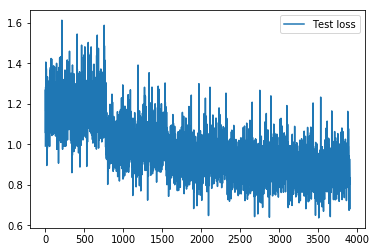

In [14]:
plt.plot(losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

### Predicting rating given user and moive id

In [15]:
movie_id_map = {val[0]:i for i, val in enumerate(movies.values)}

In [16]:
def rating_movie(user_id_val, movie_id_val):
    
    with tf.Session() as sess:  
        model.saver.restore(sess, model_file)
        
        genres = np.zeros([1, 18])
        genres[0] = movies.values[movie_id_map[movie_id_val]][2]
    
        titles = np.zeros([1, movie_title_len])
        titles[0] = movies.values[movie_id_map[movie_id_val]][1]
    
        feed = {
              model.user_id: np.reshape(users.values[user_id_val-1][0], [1, 1]),
              model.user_gender: np.reshape(users.values[user_id_val-1][1], [1, 1]),
              model.user_age: np.reshape(users.values[user_id_val-1][2], [1, 1]),
              model.user_job: np.reshape(users.values[user_id_val-1][3], [1, 1]),
              model.movie_id: np.reshape(movies.values[movie_id_map[movie_id_val]][0], [1, 1]),
              model.movie_genres: genres,  
              model.movie_titles: titles,  
              model.dropout_keep_prob: 1
        }
    
        # Get Prediction
        pred_rating= sess.run([model.pred_ratings], feed)  
    
        return (pred_rating)

In [17]:
rating_movie(2, 1193)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/final_movies_recommendations_model


[array([[4.5714545]], dtype=float32)]

## 4. Users and Movies Feature Matrix

### Users Feature Matrix

In [18]:
users_feature_matrix = []

with tf.Session() as sess:  
    model.saver.restore(sess, model_file)

    for user in users.values:
        
        feed = {
              model.user_id: np.reshape(user[0], [1, 1]),
              model.user_gender: np.reshape(user[1], [1, 1]),
              model.user_age: np.reshape(user[2], [1, 1]),
              model.user_job: np.reshape(user[3], [1, 1]), 
              model.dropout_keep_prob: 1
        }
        
        user_feature = sess.run([model.user_combine_layer_flat], feed)
        users_feature_matrix.append(user_feature)

users_feature_matrix = np.squeeze(np.array(users_feature_matrix))
users_feature_matrix.shape

INFO:tensorflow:Restoring parameters from models/final_movies_recommendations_model


(6040, 200)

### Moives Feature Matrix

In [19]:
movies_feature_matrix = []

with tf.Session() as sess:  
    model.saver.restore(sess, model_file)

    for movie in movies.values:
        
        genres = np.zeros([1, 18])
        genres[0] = movie[2]
    
        titles = np.zeros([1, movie_title_len])
        titles[0] = movie[1]
        
        feed = {
              model.movie_id: np.reshape(movie[0], [1, 1]),
              model.movie_genres: genres,  
              model.movie_titles: titles,  
              model.dropout_keep_prob: 1
        }
        
        movie_feature = sess.run([model.movie_combine_layer_flat], feed)
        movies_feature_matrix.append(movie_feature)

movies_feature_matrix = np.squeeze(np.array(movies_feature_matrix))
movies_feature_matrix.shape

INFO:tensorflow:Restoring parameters from models/final_movies_recommendations_model


(3883, 200)

## 5. Recommendation

### 1. Top k movies that user may favorite

In [20]:
def top_k_favorite_movie(user_id, k = 10):
    
    user_feature = np.array(users_feature_matrix[user_id - 1]).reshape([1, 200])
    similarity = user_feature @ movies_feature_matrix.T
    best_movies_id = np.argsort(similarity)
    best_movies_id = best_movies_id[0][::-1][:2*k+1]
    random.shuffle(best_movies_id)
    return best_movies_id[:k+1]

def print_movies_by_id(movies_id):
    print("\nOur Recommendation:")
    print("-------------------")
    for movie_id in movies_id[1:]:
        movie = movies_old.iloc[movie_id]
        title = movie['title']
        genres = movie['genres']
        print("[" + str(movie_id) + "] title : " +title) 
        print("genres: " +genres)
        print("-------------------")

In [21]:
print_movies_by_id(top_k_favorite_movie(19, 10))


Our Recommendation:
-------------------
[600] title : Criminals (1996)
genres: Documentary
-------------------
[847] title : Godfather, The (1972)
genres: Action|Crime|Drama
-------------------
[1172] title : Thin Blue Line, The (1988)
genres: Documentary
-------------------
[523] title : Schindler's List (1993)
genres: Drama|War
-------------------
[711] title : Wallace & Gromit: The Best of Aardman Animation (1996)
genres: Animation
-------------------
[1132] title : Wrong Trousers, The (1993)
genres: Animation|Comedy
-------------------
[780] title : An Unforgettable Summer (1994)
genres: Drama
-------------------
[315] title : Shawshank Redemption, The (1994)
genres: Drama
-------------------
[2130] title : Phoenix (1998)
genres: Crime|Drama
-------------------
[1215] title : Sting, The (1973)
genres: Comedy|Crime
-------------------


### 2.  Other Movies you might like if you watched this movie

In [22]:
def other_movies_you_might_like(movie_id, k = 10):
    
    watched_movie = movies_old.iloc[movie_id]
    print("======================================")
    print("The movie you watched: " + watched_movie['title'])
    print("======================================")
    
    movie_feature = np.array(movies_feature_matrix[movie_id_map[movie_id]]).reshape([1,200])
    users_similarity = movie_feature @ users_feature_matrix.T
    also_liked_user_id = np.argsort(users_similarity)
    also_liked_user_id = also_liked_user_id[0][::-1][:k]
    
    common_movies_id = {}
    for user_id in also_liked_user_id:
        favorite_movies_id = top_k_favorite_movie(user_id, 10)
        for movie_id in favorite_movies_id:
            if(movie_id in common_movies_id):
                common_movies_id[movie_id] += 1
            else:
                common_movies_id[movie_id] = 1
    
    sorted_common_movies_id = sorted(common_movies_id.items(), key = lambda x : (x[1], x[0]),
                                    reverse = True)
    other_movies_id = []
    for movie_id in sorted_common_movies_id:
        if(len(other_movies_id) < 2*k):
            other_movies_id.append(movie_id[0])
        
    random.shuffle(other_movies_id)    
    return other_movies_id[:k+1]

In [23]:
print_movies_by_id(other_movies_you_might_like(3))

The movie you watched: Waiting to Exhale (1995)

Our Recommendation:
-------------------
[711] title : Wallace & Gromit: The Best of Aardman Animation (1996)
genres: Animation
-------------------
[847] title : Godfather, The (1972)
genres: Action|Crime|Drama
-------------------
[2439] title : Breaks, The (1999)
genres: Drama
-------------------
[1194] title : Third Man, The (1949)
genres: Mystery|Thriller
-------------------
[2282] title : Nights of Cabiria (Le Notti di Cabiria) (1957)
genres: Drama
-------------------
[1162] title : Paths of Glory (1957)
genres: Drama|War
-------------------
[900] title : Casablanca (1942)
genres: Drama|Romance|War
-------------------
[1264] title : Big Sleep, The (1946)
genres: Film-Noir|Mystery
-------------------
[2130] title : Phoenix (1998)
genres: Crime|Drama
-------------------
[3366] title : Double Indemnity (1944)
genres: Crime|Film-Noir
-------------------


### 3. Similiar movies

In [24]:
def similar_movies(movie_id, k=20):
    watched_movie = movies_old.iloc[movie_id]
    print("======================================")
    print("The movie you watched: " + watched_movie['title'])
    print("======================================")
    
    movie_feature = np.array(movies_feature_matrix[movie_id_map[movie_id]]).reshape([1,200])
    similarity = movie_feature @ movies_feature_matrix.T
    best_movies_id = np.argsort(similarity)
    best_movies_id = best_movies_id[0][::-1][:k+1]
    
    random.shuffle(best_movies_id)
    return best_movies_id[:k+1]

In [25]:
print_movies_by_id(similar_movies(1219, 10))

The movie you watched: Local Hero (1983)

Our Recommendation:
-------------------
[2933] title : My Best Fiend (Mein liebster Feind) (1999)
genres: Documentary
-------------------
[781] title : Last Klezmer: Leopold Kozlowski, His Life and Music, The (1995)
genres: Documentary
-------------------
[3611] title : Decline of Western Civilization Part II: The Metal Years, The (1988)
genres: Documentary
-------------------
[2840] title : Five Wives, Three Secretaries and Me (1998)
genres: Documentary
-------------------
[29] title : Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
genres: Drama
-------------------
[125] title : Silence of the Palace, The (Saimt el Qusur) (1994)
genres: Drama
-------------------
[1340] title : Paradise Lost: The Child Murders at Robin Hood Hills (1996)
genres: Documentary
-------------------
[1095] title : Microcosmos (Microcosmos: Le peuple de l'herbe) (1996)
genres: Documentary
-------------------
[3113] title : Mr. Death: The Rise and Fall of Fred A. 